**Authors:** Alex THELANDER, Johanna ENGSNER, Aape HARTIKAINEN, Vladimir BLIZNIUKOV. \\
[**Video link**](https://polimi365-my.sharepoint.com/:v:/g/personal/11034644_polimi_it/Eey-WvZDQgBKua3H5YlJaBMBatTUWWoQBeGhfUUCYT-VvA?e=vGBpy1)

## Introduction

In this notebook, we have made a workflow on the eHoVy RACE reading-comprehension dataset from Hugging Face. We begin with data loading and **preliminary analysis** to understand the structure, vocabulary and class balance of the dataset.

Next, we train and compare a variety of models:

1. **Simple baselines** (TF-IDF + logistic regression)  
2. **Sequence models** (LSTM-based classifier)  
3. **Large language model (LLM) zero-shot/feature-based** approaches  
4. **Fine-tuning an LLM** (flan T5) with Lora

Finally, we explore a few **extensions**:

- Applying our pipeline to **additional datasets** with the best fine-tuned ALBERT model
- Building a **distractor-generation model** to automatically craft plausible but incorrect answer choices  

> **Note:** For convenience, cells with all required `pip install` commands, imports and data-loading steps are spread throughout the notebook so you can rerun each section independently, but make sure to run the loading of data before any other cell, otherwise the notebook breaks.


# Loading of Data - run before any other cell

In [ ]:
# Colab setup: upgrade fsspec & friends, then install all deps
!pip install --upgrade pip
!pip install -U datasets
!pip install --upgrade fsspec s3fs gensim numpy
!pip install datasets transformers torch tqdm scipy scikit-learn

  Using cached fsspec-2025.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached fsspec-2025.5.0-py3-none-any.whl (196 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.5.0 which is incompatible.
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.0
    Uninstalling fsspec-2025.5.0:
  

In [ ]:
#Install the datasets library
!pip install -q datasets

from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

race = load_dataset("ehovy/race", "all")

#inspect the available splits
print(race)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.08M [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/37.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4934 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/87866 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4887 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4934
    })
    train: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 87866
    })
    validation: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4887
    })
})


# Part 1 - Preliminary Analysis of the Data

In [ ]:
print(f"Length per split (number of datapoints):\n train: {len(race['train'])},\n test: {len(race['test'])},\n validation: {len(race['validation'])}")

Length per split (number of datapoints):
 train: 87866,
 test: 4934,
 validation: 4887


### Race dataset to pandas data frame

In [ ]:
import pandas as pd
def flatten_race_batch(batch):
    new_batch = {
        "article": [],
        "question": [],
        "options": [],
        "answer": []
    }
    for article, question, options, answer in zip( batch["article"], batch["question"], batch["options"], batch["answer"]):
            new_batch["article"].append(article)
            new_batch["question"].append(question)
            new_batch["options"].append(options)
            new_batch["answer"].append(answer)
    return new_batch

# Apply with batched=True
flat_train = pd.DataFrame(race["train"].map(flatten_race_batch, batched=True, remove_columns=race["train"].column_names))
flat_train["split"] = "train"
flat_val = pd.DataFrame(race["validation"].map(flatten_race_batch, batched=True, remove_columns=race["validation"].column_names))
flat_val["split"] = "validation"
flat_test = pd.DataFrame(race["test"].map(flatten_race_batch, batched=True, remove_columns=race["test"].column_names))
flat_test["split"] = "test"

# Convert to pandas DataFrame
df_race = pd.concat([flat_train, flat_val, flat_test])

letter_to_index = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

df_race["correct_answer"] = df_race.apply(
    lambda row: row["options"][letter_to_index[row["answer"]]],
    axis=1
)
# map letter answer to a number
df_race["answer_num"] = df_race["answer"].replace(letter_to_index)
df_race.head()

Map:   0%|          | 0/87866 [00:00<?, ? examples/s]

Map:   0%|          | 0/4887 [00:00<?, ? examples/s]

Map:   0%|          | 0/4934 [00:00<?, ? examples/s]

<ipython-input-3-87a79e1a74fa>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_race["answer_num"] = df_race["answer"].replace(letter_to_index)


,article,answer,question,options,split,correct_answer,answer_num
0,Last week I talked with some of my students ab...,C,We can know from the passage that the author w...,"[doctor, model, teacher, reporter]",train,teacher,2
1,Last week I talked with some of my students ab...,C,Many graduates today turn to cosmetic surgery ...,"[marry a better man/woman, become a model, get...",train,get an advantage over others in job-hunting,2
2,Last week I talked with some of my students ab...,D,"According to the passage, the author believes ...","[everyone should purchase perfection, whatever...",train,media are to blame for misleading young people...,3
3,Last week I talked with some of my students ab...,B,Which' s the best title for the passage?.,"[Young Graduates Have Higher Expectations, You...",train,Young Graduates Look to Surgery for Better Jobs,1
4,"YUZHOU, HENAN -An accident in a central China ...",B,What could be the best title for this passage?,"[Death Toll Rises in an Accident in China, A C...",train,A Coal Mine Accident in Central China,1


## Question and Answer distributions per article

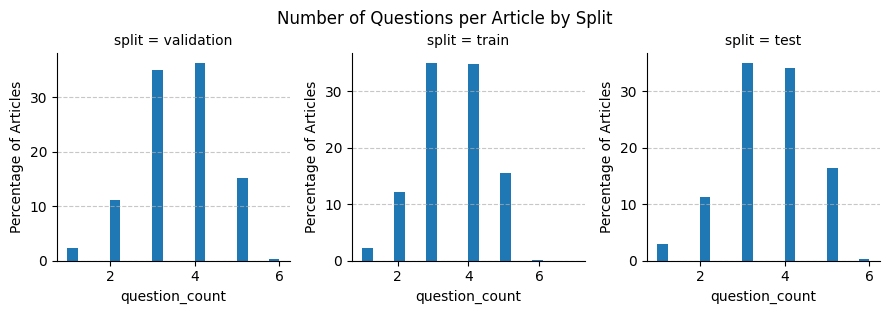

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# rpoup by article and split and count the number of questions
article_question_counts = df_race.groupby(['article', 'split']).size().reset_index(name='question_count')

def percent_hist(x, **kwargs):
    # plot histogram normalized (density=True)
    weights = (100 / len(x)) * pd.Series([1] * len(x))
    plt.hist(x, bins=20, weights=weights, **kwargs)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel("Number of Questions")
    plt.ylabel("Percentage of Articles")

# create grid with split-wise histograms (train, test, validation)
g = sns.FacetGrid(article_question_counts, col="split", sharey=False, sharex=False)
g.map(percent_hist, "question_count")
g.fig.suptitle('Number of Questions per Article by Split', y=1.03)

plt.show()

**Note:** There are articles that contain only one question, moreover, in both train and test the number of 3-question articles is the highest.

In [ ]:
# filter articles with exactly one question
articles_with_one_question = article_question_counts[article_question_counts['question_count'] == 1]

# count the number of such articles per split
articles_per_split_one_question = articles_with_one_question.groupby('split').size().reset_index(name='article_count')

print("Number of articles with one question per split:")
articles_per_split_one_question

Number of articles with one question per split:


,split,article_count
0,test,42
1,train,572
2,validation,31


In [ ]:
# find the article with the maximum number of questions
article_with_most_questions = article_question_counts.loc[article_question_counts['question_count'].idxmax()]

print("Article with the most number of questions:", article_with_most_questions["question_count"],"questions in", article_with_most_questions["split"])

article_with_most_questions["article"]

Article with the most number of questions: 7 questions in train


"In the 1500s, South American fishermen said that the sea became warmer every few years. They gave this special event a Spanish name 'El Nino', meaning 'the baby'. It is called 'the baby' because it arrives around Christmas.\nEl Nino is a huge area of warm water in the middle of cold water in the Pacific Ocean. It happens every two to seven years. It moves around the ocean and becomes bigger and smaller at different times. This warm water affects the weather. It is always raining over El Nino. El Nino contains a lot of energy. Scientists think this energy is formed when wind comes from the northern half of the world. The winds blow across warm sea water in the south. When the strong wind hits the warm water, violent weather happens. Scientists think that El Nino existed for many thousands of years.\nEl Nino affects every person in the world because it affects the entire world's weather. It can bring the rain that farmers need. It can bring storms that destroy homes. It can mean that fi

In [ ]:
# find the article with the maximum count for answer 'A'
# calculate the count of each answer choice ('A', 'B', 'C', 'D') for each article
answer_counts_per_article = df_race.groupby('article')['answer'].value_counts().unstack(fill_value=0)

article_with_most_A = answer_counts_per_article['A'].idxmax()
max_A_count = answer_counts_per_article['A'].max()

print(f"Article with the most number of answer 'A':\n")
print(f"Article content:\n{article_with_most_A}")
print(f"\nNumber of 'A' answers in this article: {max_A_count}")

# optionally, display all answers for this article
print(f"\nAnswer distribution for this article:")
print(answer_counts_per_article.loc[article_with_most_A].values)

Article with the most number of answer 'A':

Article content:
Doctors have known for a long time that extremely loud noises can cause hearing damage or loss. The noise can be the sound of a jet airplane or machines in factories of loud music or other common sound at home and at work. A person only needs to hear the noise for little more than one second to be affected.
An American scientist has found that using aspirin   increase the temporary  hearing loss or damage from loud noise. He did an experiment using a number of students at a university who all had normal hearing. He gave them different amounts of aspirin for different periods of time, then he tested their hearing ability. He found that students who were given four grams of aspirin a day for two days suffered much greater temporary hearing loss than those who did not use aspirin. The hearing loss was about two times as great.
The scientist said millions of persons in the U.S. use much larger amounts of aspirin than were used i

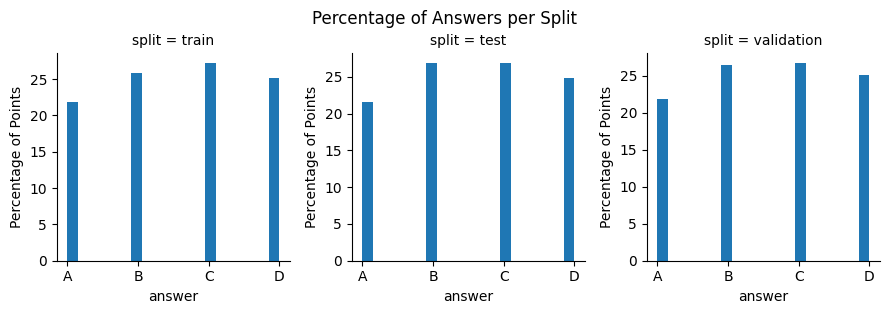

In [ ]:
def percent_hist(x, **kwargs):
    # plot histogram normalized (density=True)
    weights = (100 / len(x)) * pd.Series([1] * len(x))
    plt.hist(x, bins=20, weights=weights, **kwargs)
    plt.xlabel("Number of Questions")
    plt.ylabel("Percentage of Points")

# create grid with split-wise histograms
g = sns.FacetGrid(df_race.sort_values(["answer"]), col="split", sharey=False, sharex=False)
g.map(percent_hist, "answer")
g.fig.suptitle('Percentage of Answers per Split', y=1.03)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Note:** The distribution is almost equivalent in all splits, perhaps, in train the answer B is less common

In [ ]:
df_race.groupby(["split", "article"]).agg(q_count=("question", "count")).groupby("split").agg(avg_question_per_article=("q_count", "mean")).reset_index()

,split,avg_question_per_article
0,test,3.506752
1,train,3.495763
2,validation,3.518359


In [ ]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import pandas as pd

def get_max_str(str_list):
  return str_list[np.argmax([len(s) for s in str_list])]

def plot_info(df_names, splits, unique_flag=False):
    # seaborn style
    sns.set(style="whitegrid")

    token_pattern = re.compile(r'\b\w+\b')
    if len(df_names) > 1:
        df = []
        for split in splits:
            for ex in race[split]:
                # lower‐case and split out words from df_names
                text = " ".join([ex[df_name] if type(ex[df_name]) == str else get_max_str(ex[df_name]) for df_name in df_names ])
                df.append(text)
    else:
      df = []
      for split in splits:
        df += race[split][df_names[0]]
    if unique_flag:
      df = set(df)
    tokens = [token_pattern.findall(a.lower()) for a in df]

    # calculate statistics on tokenized data

    lengths = np.array([len(toks) for toks in tokens])
    vocab_sizes = np.array([len(set(toks)) for toks in tokens])
    collection_vocab = {tok for toks in tokens for tok in toks}

    # Compute percentiles and min/max
    percentiles = np.percentile(lengths, [0, 25, 50, 75, 100])
    labels = ["Min", "25th", "Median", "75th", "Max"]

    # Create plt figure
    plt.figure(figsize=(12, 4))
    title = ' + '.join([df_name.capitalize() for df_name in df_names])

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(lengths, bins=50, kde=True, color='skyblue')
    plt.title(f"{title} Length Distribution (Histogram)")
    plt.xlabel(f"{title} Length (# words)")
    plt.ylabel("Frequency")

    mean = np.round(lengths.mean(),1)
    plt.axvline(np.round(lengths.mean(),1), color='red', linestyle='--')
    plt.text(mean, plt.ylim()[1]*0.4, f'Avg Length: {mean}', color='red', rotation=90)

    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=lengths, color='lightgreen')
    plt.title(f"{title} Length Distribution (Box Plot)")
    plt.xlabel(f"{title} Length (# words)")

    # Add labels on the box plot
    for p, label in zip(percentiles, labels):
        plt.text(p, 0.02, f'{label}: {int(p)}', rotation=90, verticalalignment='bottom', color='darkblue')

    # Show the plots
    plt.tight_layout()
    plt.show()

    stats = {
    "Metric": [
        "Number of points",
        "Collection vocab size",
        "Average unique tokens per example"
    ],
    "Value": [len(df),
              len(collection_vocab),\
              np.round(vocab_sizes.mean(),1)]
    }

    display(Markdown(f"## {title} info"))
    display(pd.DataFrame(stats))

## Lengths distribution of Article, Questions, Options


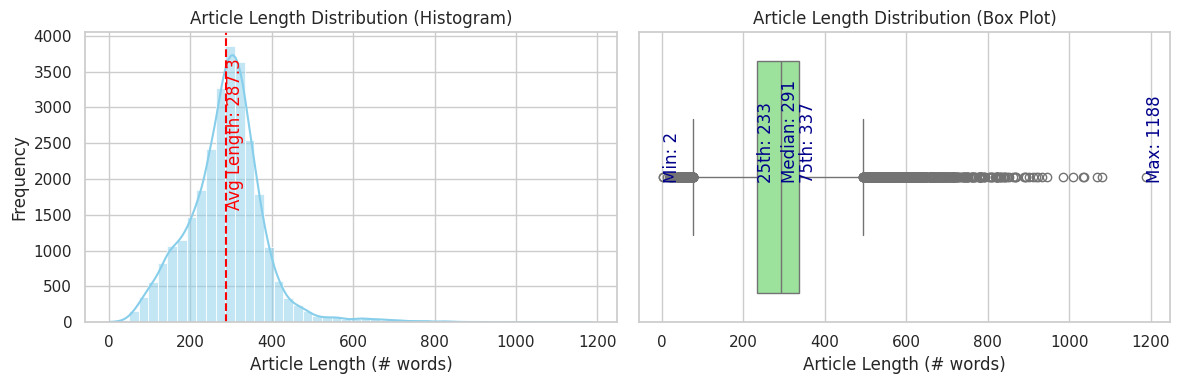

## Article info

,Metric,Value
0,Number of points,27931.0
1,Collection vocab size,75870.0
2,Average unique tokens per example,156.3


In [ ]:
# plot info about UNIQUE articles in all splits
plot_info(["article"],["train", "validation", "test"], True) # last parameter refers to uniquness

In [ ]:
df_race.loc[df_race["article"].str.findall(r'\b\w+\b').str.len() < 10] # look at the articles that are less than 10 words

,article,answer,question,options,split,correct_answer,answer_num
37892,STUDY CENTER COURSES,A,"If a student takes the course The Short Story,...","[From Paragraph to Essay, Tense about Tenses, ...",train,From Paragraph to Essay,0
37893,STUDY CENTER COURSES,B,Which of the courses can develop the students'...,"[From Paragraph to Essay, The Short Story, Cau...",train,The Short Story,1
37894,STUDY CENTER COURSES,D,From where can a student read this?,"[On the radio., On television., In a local new...",train,On a school notice board.,3
70067,Passage 1,C,"After reading this, we know this is _ .","[a studying plan of Edward Scott, A teaching p...",train,a school report of Edward Scott,2
70068,Passage 1,A,Which of the following is Not mentioned in th...,"[PE., Music., Math, History.]",train,PE.,0
70069,Passage 1,B,Edward's best subject is _ .,"[Science, English, geography, History]",train,English,1
70070,Passage 1,B,Edward is not good at _ .,"[Science and geography, Math and history, Fren...",train,Math and history,1
70071,Passage 1,C,"According to the form, which of the following ...","[Edward can't sing songs very well., Edward do...",train,Edward can do better if he works harder next.,2


**Note:** These articles contain no significant information, yet they have valid questions + answers

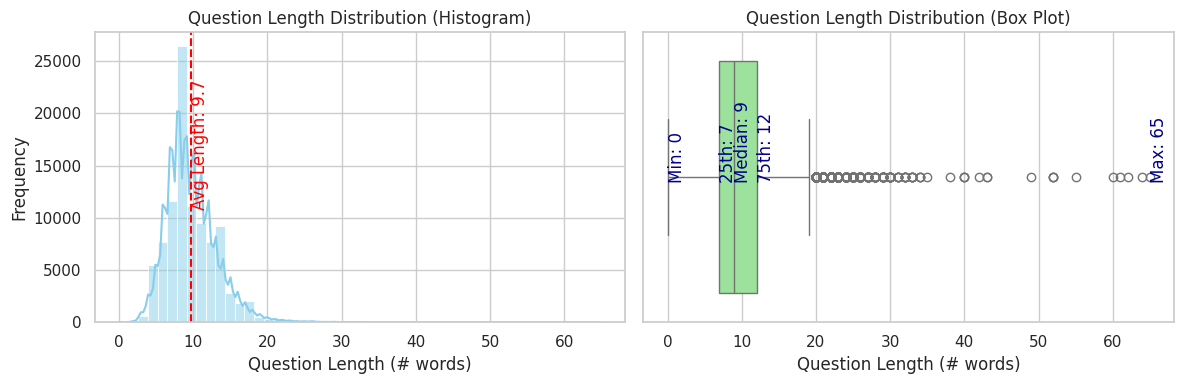

## Question info

,Metric,Value
0,Number of points,97687.0
1,Collection vocab size,22749.0
2,Average unique tokens per example,9.3


In [ ]:
plot_info(["question"],["train", "validation", "test"], unique_flag=False)

In [ ]:
df_race.loc[df_race["question"].str.findall(r'\b\w+\b').str.len() == 0].shape

(18, 7)

In [ ]:
df_race.loc[df_race["question"].str.findall(r'\b\w+\b').str.len() < 3] # questions shortes than 3 words

,article,answer,question,options,split,correct_answer,answer_num
788,When did you see a polar bear ? On a trip to a...,A,Doctors _ .,[have different ideas about the medical effect...,train,have different ideas about the medical effects...,0
1258,"In the United States, friendships can be close...",B,.,"[different languages, naughty children, differ...",train,naughty children,1
2189,"Last year we visited prefix = st1 /Stratford, ...",B,Stratfordis _ .,"[a church, in the middle of England, a very la...",train,in the middle of England,1
3550,The regular use of text messages and e-mails c...,A,.,"[children whose parents care about them, child...",train,children whose parents care about them,0
4332,"Mr. Laurence was not allowed to see Beth, and ...",B,Amy _ .,[was at Aunt March's house to help with the ho...,train,was somewhat self-centered in the earlier part...,1
...,...,...,...,...,...,...,...
1458,"When, after a year of being alone on his islan...",A,Daniel Defoe_.,"[made his living as a writer, got his start as...",test,made his living as a writer,0
3541,"Lucy:I like sports. I have ten tennis balls, s...",A,Alice _ .,"[has no balls, doesn't like sports, thinks pin...",test,has no balls,0
3695,As many as 10 of the 17 kinds of penguins may ...,C,Penguins _ .,"[can swim better than fly, can be found near O...",test,eat fish only,2
4218,We have two new students in our class. They ar...,D,Cindy _ .,"[likes yellow and orange, likes Chinese very m...",test,likes blue pants very much,3


**If the question length is 1,** it is most likely to give the definition of the word like in the example above for 'Doctors_.', 'Mauritiusis _ .'

**However, if the question length is 0,** it is less logical. Sometimes the question is inside the text:

The best title of the text is _ . A. Various Opinions on Japan's Nuclear Disaster B. Japan's Disaster is Likely to Run out of Control C. America Feels Great Concern for Japan's Nuclear Crisis D. Japan's Disaster Throws Doubt on Nuclear Energy Industry

**Sometimes the text itself makes no sense:**

At the same time, children whose parents read to them, take them on outings and just generally pay attention to them are less likely to become bullies, said the report from the University of Washington. Researchers also found gaps in learning and understanding such things as social skills early in life makes it more difficult for children to relate with other children. Watching violence on television leads to aggressive behavior.

*(??) - Continues with the following, which is not relevant at all.*

You could soon be able to add your favorite perfume to your e-mails. UK net provider Telewest Broadband is testing a system to let people send e-mails over the Internet with sweet smell. It has developed a kind of hi-tech air freshener that plugs into a PC and sprays a smell linked to the message. Telewest says it could be used by supermarkets to attract people with the smell of fresh bread or by holiday companies seeking to stir up images of sun-kissed beachers.

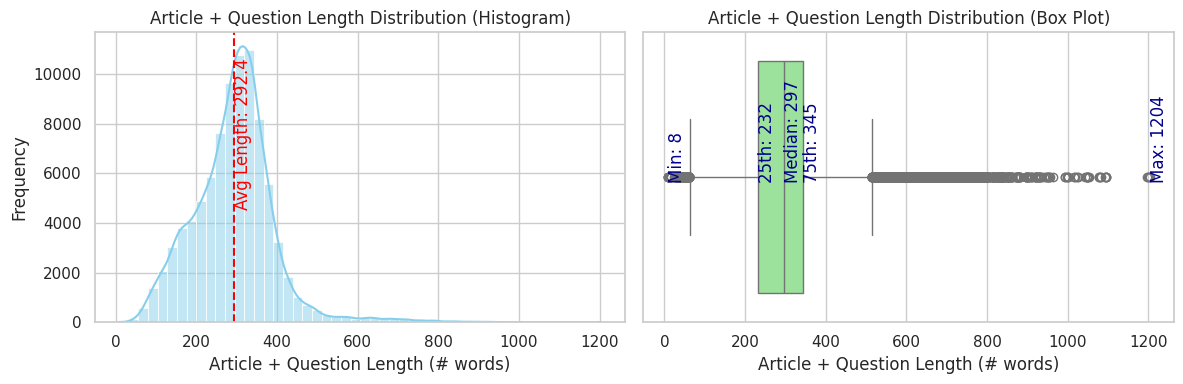

## Article + Question info

,Metric,Value
0,Number of points,87847.0
1,Collection vocab size,73562.0
2,Average unique tokens per example,156.9


In [ ]:
plot_info(["article", "question"],["train"], True) # unique combinations of article + question (to look at the length)

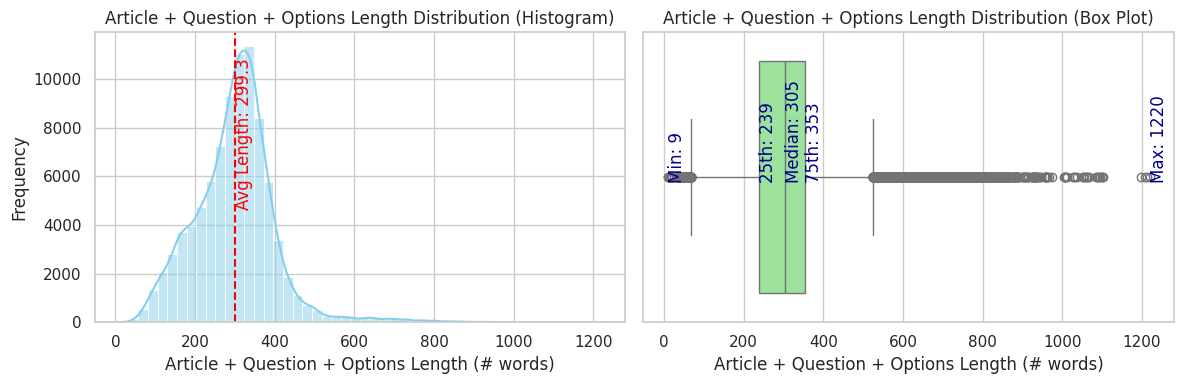

## Article + Question + Options info

,Metric,Value
0,Number of points,87865.0
1,Collection vocab size,74586.0
2,Average unique tokens per example,158.8


In [ ]:
plot_info(["article", "question", "options"],["train"], True) # unique combinations of article + question + option (to look at the length)

## Check overlapping articles

In [ ]:
# Check for duplicate articles across different splits
# We group by article content and then check if a single article appears in more than one split.
article_splits = df_race.groupby('article')['split'].nunique()

# Filter articles that appear in more than one split
duplicate_articles = article_splits[article_splits > 1]

if duplicate_articles.empty:
    print("No articles appear in multiple splits.")
else:
    print("The following articles appear in multiple splits:")
    print(duplicate_articles)

    # Optionally, display the information for one such article
    example_article = duplicate_articles.index[0]
    print(f"\nDetails for one duplicate article (first one found):")
    display(df_race[df_race['article'] == example_article])


No articles appear in multiple splits.


## Top questions

In [ ]:
# Count question frequencies and print the top 20 most common
from collections import Counter
df_race_train = df_race[df_race["split"]=="train"]
questions = df_race_train["question"].values
question_counts = Counter(questions)

# Get the 20 most common questions
top20 = question_counts.most_common(20)

print("Top 20 most common questions (with their counts):")
for question, count in top20:
    print(f"{count:5d} × {question}")

Top 20 most common questions (with their counts):
  349 × Which of the following is TRUE according to the passage?
  282 × What can we learn from the passage?
  263 × Which of the following is TRUE?
  256 × What would be the best title for the passage?
  251 × What is the passage mainly about?
  234 × Which of the following is NOT true?
  203 × What can we infer from the passage?
  180 × Which of the following is true according to the passage?
  175 × Which of the following is true?
  171 × What is the best title for the passage?
  167 × Which of the following is NOT true according to the passage?
  162 × What is the main idea of the passage?
  159 × What's the best title of the passage?
  157 × What's the main idea of the passage?
  151 × The passage is mainly about   _  .
  145 × We can learn from the passage that   _  .
  137 × What is the best title of the passage?
  134 × We can infer from the passage that   _  .
  134 × It can be inferred from the passage that   _  .
  132 × Whic

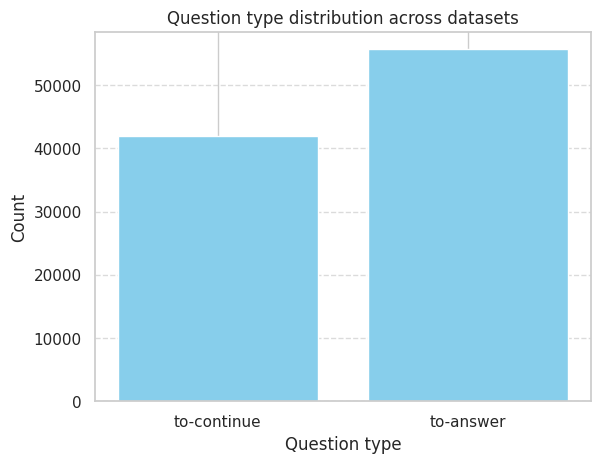

In [ ]:
df_race["question_type"] = df_race["question"].apply(lambda q: "to-continue" if q.replace(" ", "").endswith("_.") else "to-answer")
# for plotting
import matplotlib.pyplot as plt

counts = Counter(df_race["question_type"].values)
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.title(f'Question type distribution across datasets')
plt.xlabel('Question type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
!pip install -U spacy
import sys
!{sys.executable} -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.8.5
    Uninstalling spacy-3.8.5:
      Successfully uninstalled spacy-3.8.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Count POS

Processing Articles: 100%|██████████| 25135/25135 [14:13<00:00, 29.44it/s]


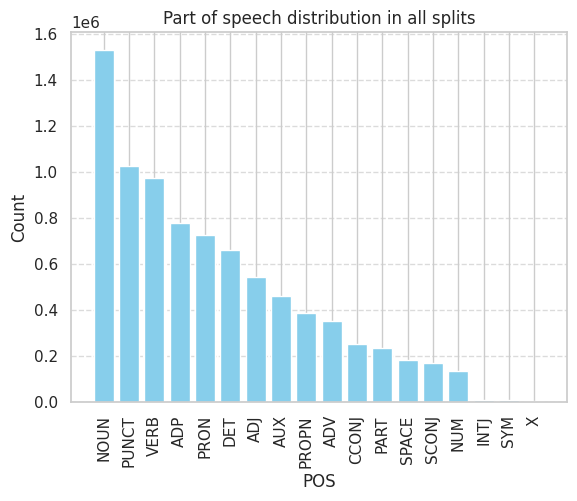

In [ ]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

# load nlp model with unused components disabled
nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat", "lemmatizer"])

# get unique articles
articles = df_race_train["article"].unique()

# use tqdm to track progress
pos_counts = Counter()
for doc in tqdm(nlp.pipe(articles, batch_size=32, n_process=1), total=len(articles), desc="Processing Articles"):
    pos_counts.update(token.pos_ for token in doc)

# plot
sorted_pairs = sorted(zip(pos_counts.keys(), pos_counts.values()), key=lambda x: x[1], reverse=True)
sorted_labels, sorted_values = zip(*sorted_pairs)
plt.bar(sorted_labels, sorted_values, color='skyblue')
plt.title('Part of speech distribution in all splits')
plt.xlabel('POS')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

Most of the terms are nouns, followed by verbs and pronouns

In [ ]:
# !pip uninstall torch -y
# !pip install torch --upgrade

In [ ]:
# import spacy
from spacy import displacy
from collections import Counter
from spacy.tokens import Span
from IPython.core.display import display, HTML

# collect all articles
articles = df_race_train["article"].unique()

def show_article_with_most_pos(pos_tag):
    """Display the article with the most occurrences of a given POS tag."""
    max_count = -1
    max_article = None
    max_doc = None
    # search for the exact tag and count
    for entry, doc in zip(tqdm(articles, desc=f"Searching for most {pos_tag}"),
                          nlp.pipe((a for a in articles), batch_size=32)):
        # divide the count by the coefficient to get the per 100 words density of text
        count = sum(1 for token in doc if token.pos_ == pos_tag)/(len(doc)//100) if len(doc) > 100 else 0
        if count > max_count:
            max_count = count
            max_article = entry
            max_doc = doc

    # output summary
    print(f"\n--- Most {pos_tag} article ---")
    print("POS count:", max_count)

    # lines to add coloring of extracted entities (actually, pos)
    ents = [Span(max_doc, i, i+1, label=pos_tag) for i, token in enumerate(max_doc) if token.pos_ == pos_tag]
    max_doc.set_ents(ents)

    # display the colorings
    colors = {pos_tag: "rgba(144, 238, 144, 0.6)"}  # light green with transparency
    options = {"ents": [pos_tag], "colors": colors}
    html = displacy.render(max_doc, style="ent", options=options, jupyter=False)
    display(HTML(html))

## Highest POS density articles

In [ ]:
show_article_with_most_pos("ADJ")   # adjectives

Searching for most ADJ: 100%|██████████| 25135/25135 [13:12<00:00, 31.70it/s]


--- Most ADJ article ---
POS count: 35.0


In [ ]:
show_article_with_most_pos("VERB")  # verbs

Searching for most VERB: 100%|██████████| 25135/25135 [13:20<00:00, 31.40it/s]


--- Most VERB article ---
POS count: 36.0


In [ ]:
show_article_with_most_pos("NOUN")  # nouns

Searching for most NOUN: 100%|██████████| 25135/25135 [13:05<00:00, 32.02it/s]


--- Most NOUN article ---
POS count: 62.0


## Word Cloud

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


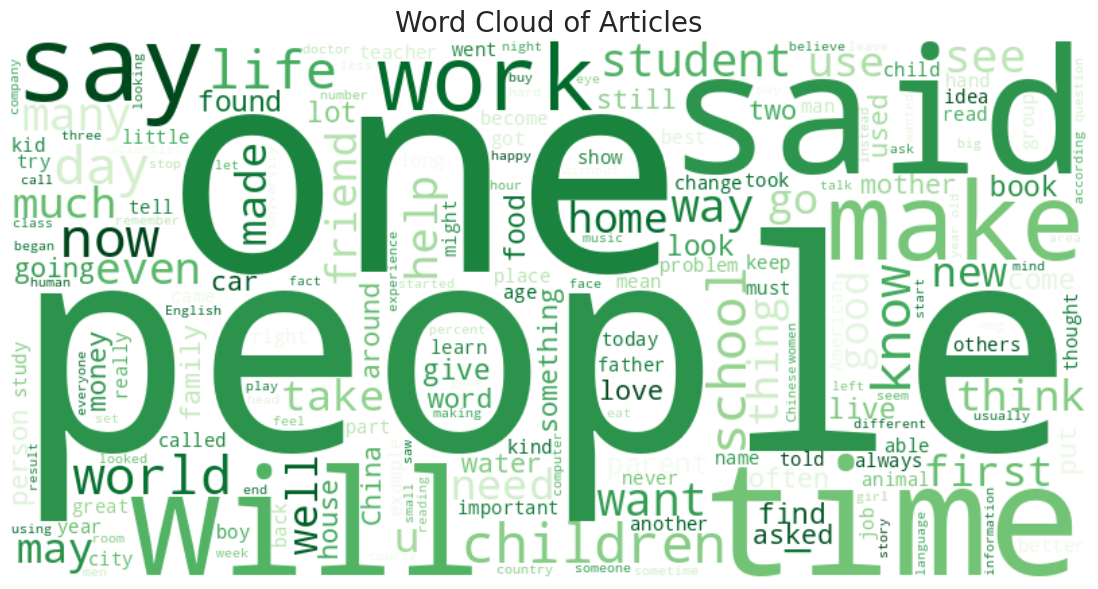

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download stopwords if not already downloaded
nltk.download('punkt_tab')
nltk.download('stopwords')

# Combine all article texts into one string
all_text = " ".join(df_race_train["article"].unique())

tokens = word_tokenize(all_text.lower())

# Remove stopwords and punctuation
filtered_tokens = [word for word in tokens
                   if word not in stopwords.words('english') and word.isalpha()]

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Articles", fontsize=20)
plt.show()

From the word cloud of train articles the most popular words are people, one, said, make, student, world, children — very logical for a high/middle school selection.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import re

def cluster_articles(texts, cleaning_function, n_clusters=10):
    # apply cleaning to the articles
    texts_cleaned = [cleaning_function(text) for text in texts]

    # TF–IDF vectorization (limit features for speed)
    tfidf = TfidfVectorizer(max_features=10_000, max_df = 0.8, min_df=5, stop_words="english")
    X_tfidf = tfidf.fit_transform(texts_cleaned)
    vocab = tfidf.get_feature_names_out()

    # K-Means clustering (for now 10 clusters)
    n_clusters = 10
    km = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = km.fit(X_tfidf)

    print("Top terms per cluster:")
    vocab = tfidf.get_feature_names_out()

    for i in range(km.n_clusters):
        centroid = km.cluster_centers_[i]
        sorted_terms = centroid.argsort()[::-1]
        print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

## Clustering articles

In [ ]:
texts = df_race_train["article"].unique()
# Original clustering for train
def clean_text_orig(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    return text.lower()

cluster_articles(texts, clean_text_orig)

Top terms per cluster:
Cluster 0:	['food', 'water', 'eat', 'fish', 'people', 'plants', 'animals', 'eating', 'vegetables', 'foods']
Cluster 1:	['people', 'internet', 'phone', 'computer', 'online', 'use', 'company', 'technology', 'information', 'car']
Cluster 2:	['students', 'school', 'schools', 'teachers', 'class', 'teacher', 'college', 'education', 'student', 'high']
Cluster 3:	['people', 'life', 'time', 'don', 'make', 'friends', 'things', 'like', 'good', 'think']
Cluster 4:	['people', 'world', 'new', 'city', 'china', 'year', 'said', 'years', 'time', 'chinese']
Cluster 5:	['said', 'man', 'mr', 'went', 'old', 'asked', 'day', 'came', 'car', 'got']
Cluster 6:	['children', 'parents', 'child', 'kids', 'school', 'time', 'family', 'help', 'said', 'learn']
Cluster 7:	['mother', 'father', 'dad', 'said', 'boy', 'day', 'son', 'mom', 'school', 'home']
Cluster 8:	['women', 'sleep', 'study', 'brain', 'people', 'researchers', 'men', 'health', 'body', 'exercise']
Cluster 9:	['english', 'language', 'ch

Cluster 0:	Food/nature \\
Cluster 1:	Technology \\
Cluster 2:	School \\
Cluster 3:	Leisure \\
Cluster 4:	?? \\
Cluster 5:	?? \\
Cluster 6:	Family \\
Cluster 7:	?? \\
Cluster 8:	Health \\
Cluster 9:	Languages \\

**Issues:** languages, language; food, foods; learning, learn; - are present in the clusters, however, give no new info => apply stemming

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import nltk
stemmer = SnowballStemmer("english")
nltk.download('punkt_tab')
# stemmed clustering for train

def clean_text_stemming(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.lower()
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in tokens] # apply stemming
    return ' '.join(stemmed)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
cluster_articles(texts, clean_text_stemming)

Top terms per cluster:
Cluster 0:	['water', 'anim', 'plant', 'dog', 'earth', 'tree', 'fish', 'peopl', 'scientist', 'bird']
Cluster 1:	['english', 'languag', 'read', 'book', 'word', 'learn', 'speak', 'use', 'peopl', 'write']
Cluster 2:	['peopl', 'friend', 'make', 'feel', 'time', 'life', 'work', 'thing', 'person', 'say']
Cluster 3:	['said', 'man', 'mother', 'day', 'father', 'ask', 'boy', 'look', 'went', 'old']
Cluster 4:	['student', 'school', 'teacher', 'class', 'colleg', 'educ', 'studi', 'learn', 'high', 'year']
Cluster 5:	['sleep', 'night', 'hour', 'bodi', 'nap', 'bed', 'asleep', 'brain', 'studi', 'time']
Cluster 6:	['peopl', 'year', 'citi', 'world', 'said', 'new', 'use', 'time', 'china', 'work']
Cluster 7:	['music', 'song', 'play', 'sing', 'listen', 'like', 'singer', 'peopl', 'piano', 'concert']
Cluster 8:	['children', 'parent', 'child', 'kid', 'school', 'famili', 'time', 'help', 'learn', 'say']
Cluster 9:	['food', 'eat', 'meal', 'peopl', 'veget', 'healthi', 'diet', 'meat', 'weight', 

More defined (logical) clusters:

Cluster 0:	Nature (more defined) \\
Cluster 1:	Languages \\
Cluster 2:	Leisure \\
Cluster 3:	['said', 'man', 'mother', 'day', 'father', 'ask', 'boy', 'look', 'went', 'old'] ?? \\
Cluster 4:	Education \\
Cluster 5:	Sleeping \\
Cluster 6:	['peopl', 'year', 'citi', 'world', 'said', 'new', 'use', 'time', 'china', 'work'] ?? \\
Cluster 7:	Music \\
Cluster 8:	Family \\
Cluster 9:	Food \\


In [ ]:
texts = df_race[df_race["split"]=="test"]["article"].unique()
cluster_articles(texts, clean_text_stemming)

Top terms per cluster:
Cluster 0:	['book', 'english', 'read', 'languag', 'chines', 'speak', 'word', 'learn', 'use', 'teacher']
Cluster 1:	['space', 'earth', 'ball', 'astronaut', 'piec', 'insect', 'star', 'fli', 'station', 'travel']
Cluster 2:	['said', 'day', 'tom', 'friend', 'went', 'mr', 'jack', 'veri', 'taxi', 'hotel']
Cluster 3:	['man', 'said', 'time', 'friend', 'thing', 'say', 'life', 'ask', 'day', 'make']
Cluster 4:	['water', 'plant', 'ice', 'drink', 'use', 'lake', 'ocean', 'peopl', 'desert', 'garden']
Cluster 5:	['peopl', 'world', 'food', 'new', 'year', 'use', 'china', 'like', 'mani', 'citi']
Cluster 6:	['dream', 'game', 'polic', 'sport', 'wish', 'peopl', 'olymp', 'player', 'said', 'play']
Cluster 7:	['anim', 'eleph', 'tree', 'kill', 'human', 'rat', 'lion', 'protect', 'food', 'eat']
Cluster 8:	['student', 'school', 'teacher', 'class', 'colleg', 'univers', 'educ', 'learn', 'test', 'high']
Cluster 9:	['children', 'parent', 'dog', 'child', 'pet', 'kid', 'school', 'famili', 'work', '

Actually, a bit different clusters on test set

Cluster 0:	Learning \\
Cluster 1:	Space \\
Cluster 2:	['said', 'day', 'tom', 'friend', 'went', 'mr', 'jack', 'veri', 'taxi', 'hotel'] ?? \\
Cluster 3:	['man', 'said', 'time', 'friend', 'thing', 'say', 'life', 'ask', 'day', 'make'] ?? \\
Cluster 4:	Water \\
Cluster 5:	['peopl', 'world', 'food', 'new', 'year', 'use', 'china', 'like', 'mani', 'citi'] ?? \\
Cluster 6:	Sports \\
Cluster 7:	Flora/Fauna \\
Cluster 8:	Education \\
Cluster 9:	Family \\

Clusters are a bit different

## Searching for number of clusters

Fitting MiniBatchKMeans with k = 2
Fitting MiniBatchKMeans with k = 3
Fitting MiniBatchKMeans with k = 4
Fitting MiniBatchKMeans with k = 5
Fitting MiniBatchKMeans with k = 6
Fitting MiniBatchKMeans with k = 7
Fitting MiniBatchKMeans with k = 8
Fitting MiniBatchKMeans with k = 9
Fitting MiniBatchKMeans with k = 10
Fitting MiniBatchKMeans with k = 11
Fitting MiniBatchKMeans with k = 12
Fitting MiniBatchKMeans with k = 13
Fitting MiniBatchKMeans with k = 14
Fitting MiniBatchKMeans with k = 15
Fitting MiniBatchKMeans with k = 16
Fitting MiniBatchKMeans with k = 17
Fitting MiniBatchKMeans with k = 18
Fitting MiniBatchKMeans with k = 19
Fitting MiniBatchKMeans with k = 20
Fitting MiniBatchKMeans with k = 21
Fitting MiniBatchKMeans with k = 22
Fitting MiniBatchKMeans with k = 23
Fitting MiniBatchKMeans with k = 24
Fitting MiniBatchKMeans with k = 25
Fitting MiniBatchKMeans with k = 26
Fitting MiniBatchKMeans with k = 27
Fitting MiniBatchKMeans with k = 28
Fitting MiniBatchKMeans with k = 29


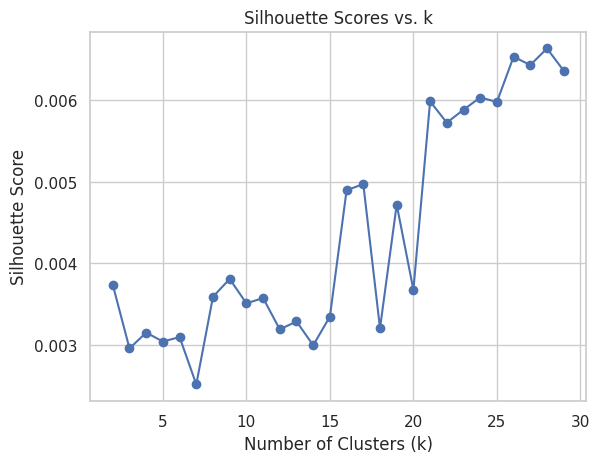

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

scores = []
labels_list = []
k_range = range(2, 30)

# get texts
texts = df_race_train["article"].unique()
# clean the texts
texts_cleaned = [clean_text_stemming(text) for text in texts]

# TF–IDF vectorization (limit features for speed)
tfidf = TfidfVectorizer(max_features=10_000, max_df = 0.8, min_df=5, stop_words="english")
X_tfidf = tfidf.fit_transform(texts_cleaned)
# get vocab
vocab = tfidf.get_feature_names_out()

for k in k_range:
    print(f"Fitting MiniBatchKMeans with k = {k}")
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024) # mini batch faster training
    labels = km.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels, sample_size=5000, random_state=42)
    scores.append((k, score))
    labels_list.append((km, labels))

# choose the best K
best_k, best_score = max(scores, key=lambda x: x[1])
print(f"\n Best number of clusters: {best_k} (silhouette score = {best_score:.3f})")

# use best model
best_km, best_labels = labels_list[best_k - 2]

# print top terms per cluster
print("\nTop terms per cluster:")
for i in range(best_k):
    centroid = best_km.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1][:10]
    top_terms = [vocab[j] for j in sorted_terms]
    print(f"Cluster {i}:\t{top_terms}")

ks, s_scores = zip(*scores)
plt.plot(ks, s_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores vs. k")
plt.grid(True)
plt.show()

Overall, the scores are really low, which does not say anything good about the clustering. Therefore, we can say that 28 clusters is the best option, however, due to the point above it makes no difference.

## Dimensionality Reduction

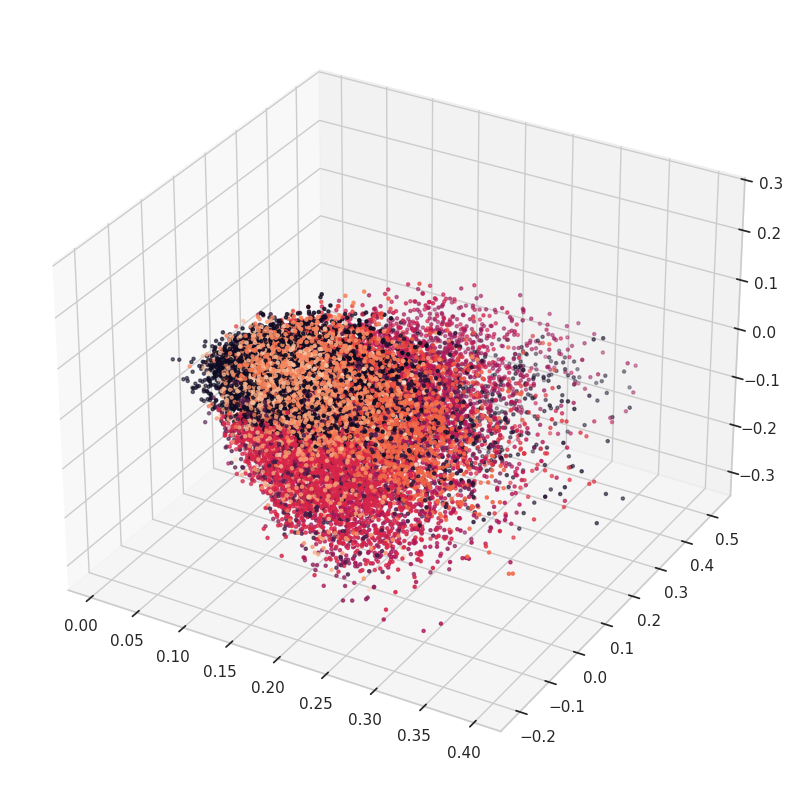

In [ ]:
from sklearn.decomposition import TruncatedSVD
# reduced dimentions of document vectors (SVD)
svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(X_tfidf)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=km.labels_, marker='.');
plt.show()

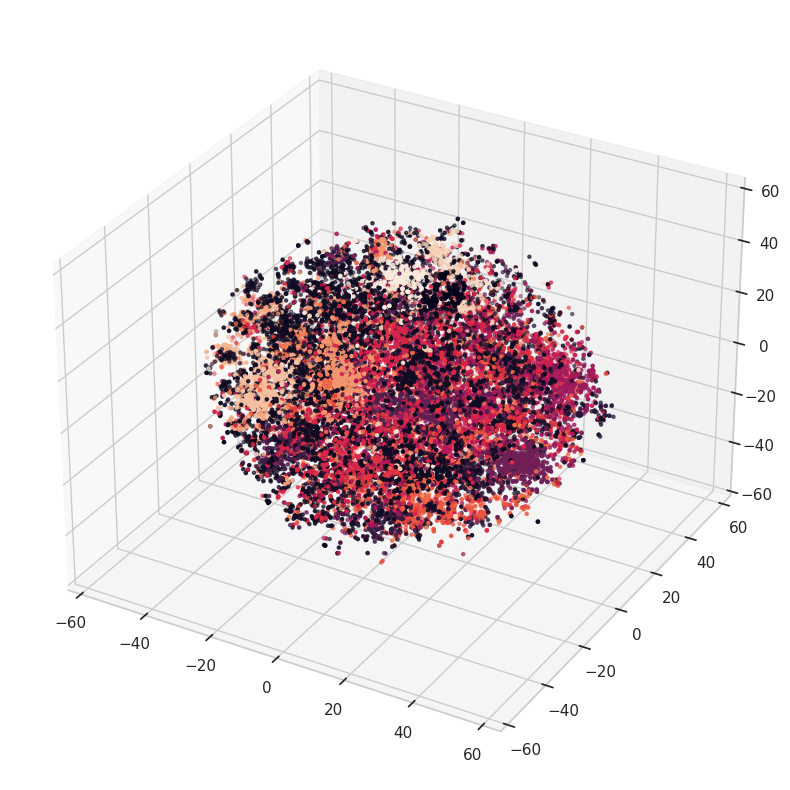

In [ ]:
from sklearn.manifold import TSNE
# reduced dimentions of document vectors (t-SNE)
texts = df_race_train["article"].unique()

texts_cleaned = [clean_text_stemming(text) for text in texts]

tfidf = TfidfVectorizer(max_features=10_000, max_df = 0.8, min_df=5, stop_words="english")
X_tfidf = tfidf.fit_transform(texts_cleaned)
vocab = tfidf.get_feature_names_out()

tsne = TSNE(n_components=3, random_state=42) # call tsne
tsne_results = tsne.fit_transform(X_tfidf.toarray())

[x, y, z] = np.transpose(tsne_results)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=km.labels_, marker='.')
plt.show()

## Latent Dirichlet Analysis

In [ ]:
pip install --upgrade pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you ha

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model  # updated import
import matplotlib.pyplot as plt
import seaborn as sns

# load train and test sets
texts_train = df_race_train["article"].unique()
texts_test = df_race[df_race["split"]=="test"]["article"].unique()


# clean the articles (stemming from previous step)
cleaned_texts_train = [clean_text_stemming(text) for text in texts_train]

# use count vectoriser for LDA (generative model)
vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
vector_documents_train = vectorizer.fit_transform(cleaned_texts_train)
vocab = vectorizer.get_feature_names_out()

# fit LDA
lda = LatentDirichletAllocation(n_components=30, verbose=1, learning_method='online', max_iter=30)
lda.fit(vector_documents_train)

# evaluating generalization of lda on test split
cleaned_texts_test = [clean_text_stemming(text) for text in texts_test]
vector_documents_test = vectorizer.transform(cleaned_texts_test)
print(lda.perplexity(vector_documents_test))

for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
4094.8972978631796
Topic 1:	 [chines, china, game, said, year, sport, team, beij, play, world]
Topic 2:	 [sai

In [ ]:
# LDA for 20 topics
lda = LatentDirichletAllocation(n_components=30, verbose=1, learning_method='online', max_iter=30)
lda.fit(vector_documents_train)

# evaluating generalization of lda on test split
cleaned_texts_test = [clean_text_stemming(text) for text in texts_test]
vector_documents_test = vectorizer.transform(cleaned_texts_test)
print(lda.perplexity(vector_documents_test))

for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
4133.743925094797
Topic 1:	 [research, studi, said, say, scientist, univers, percent, accord, report, human]


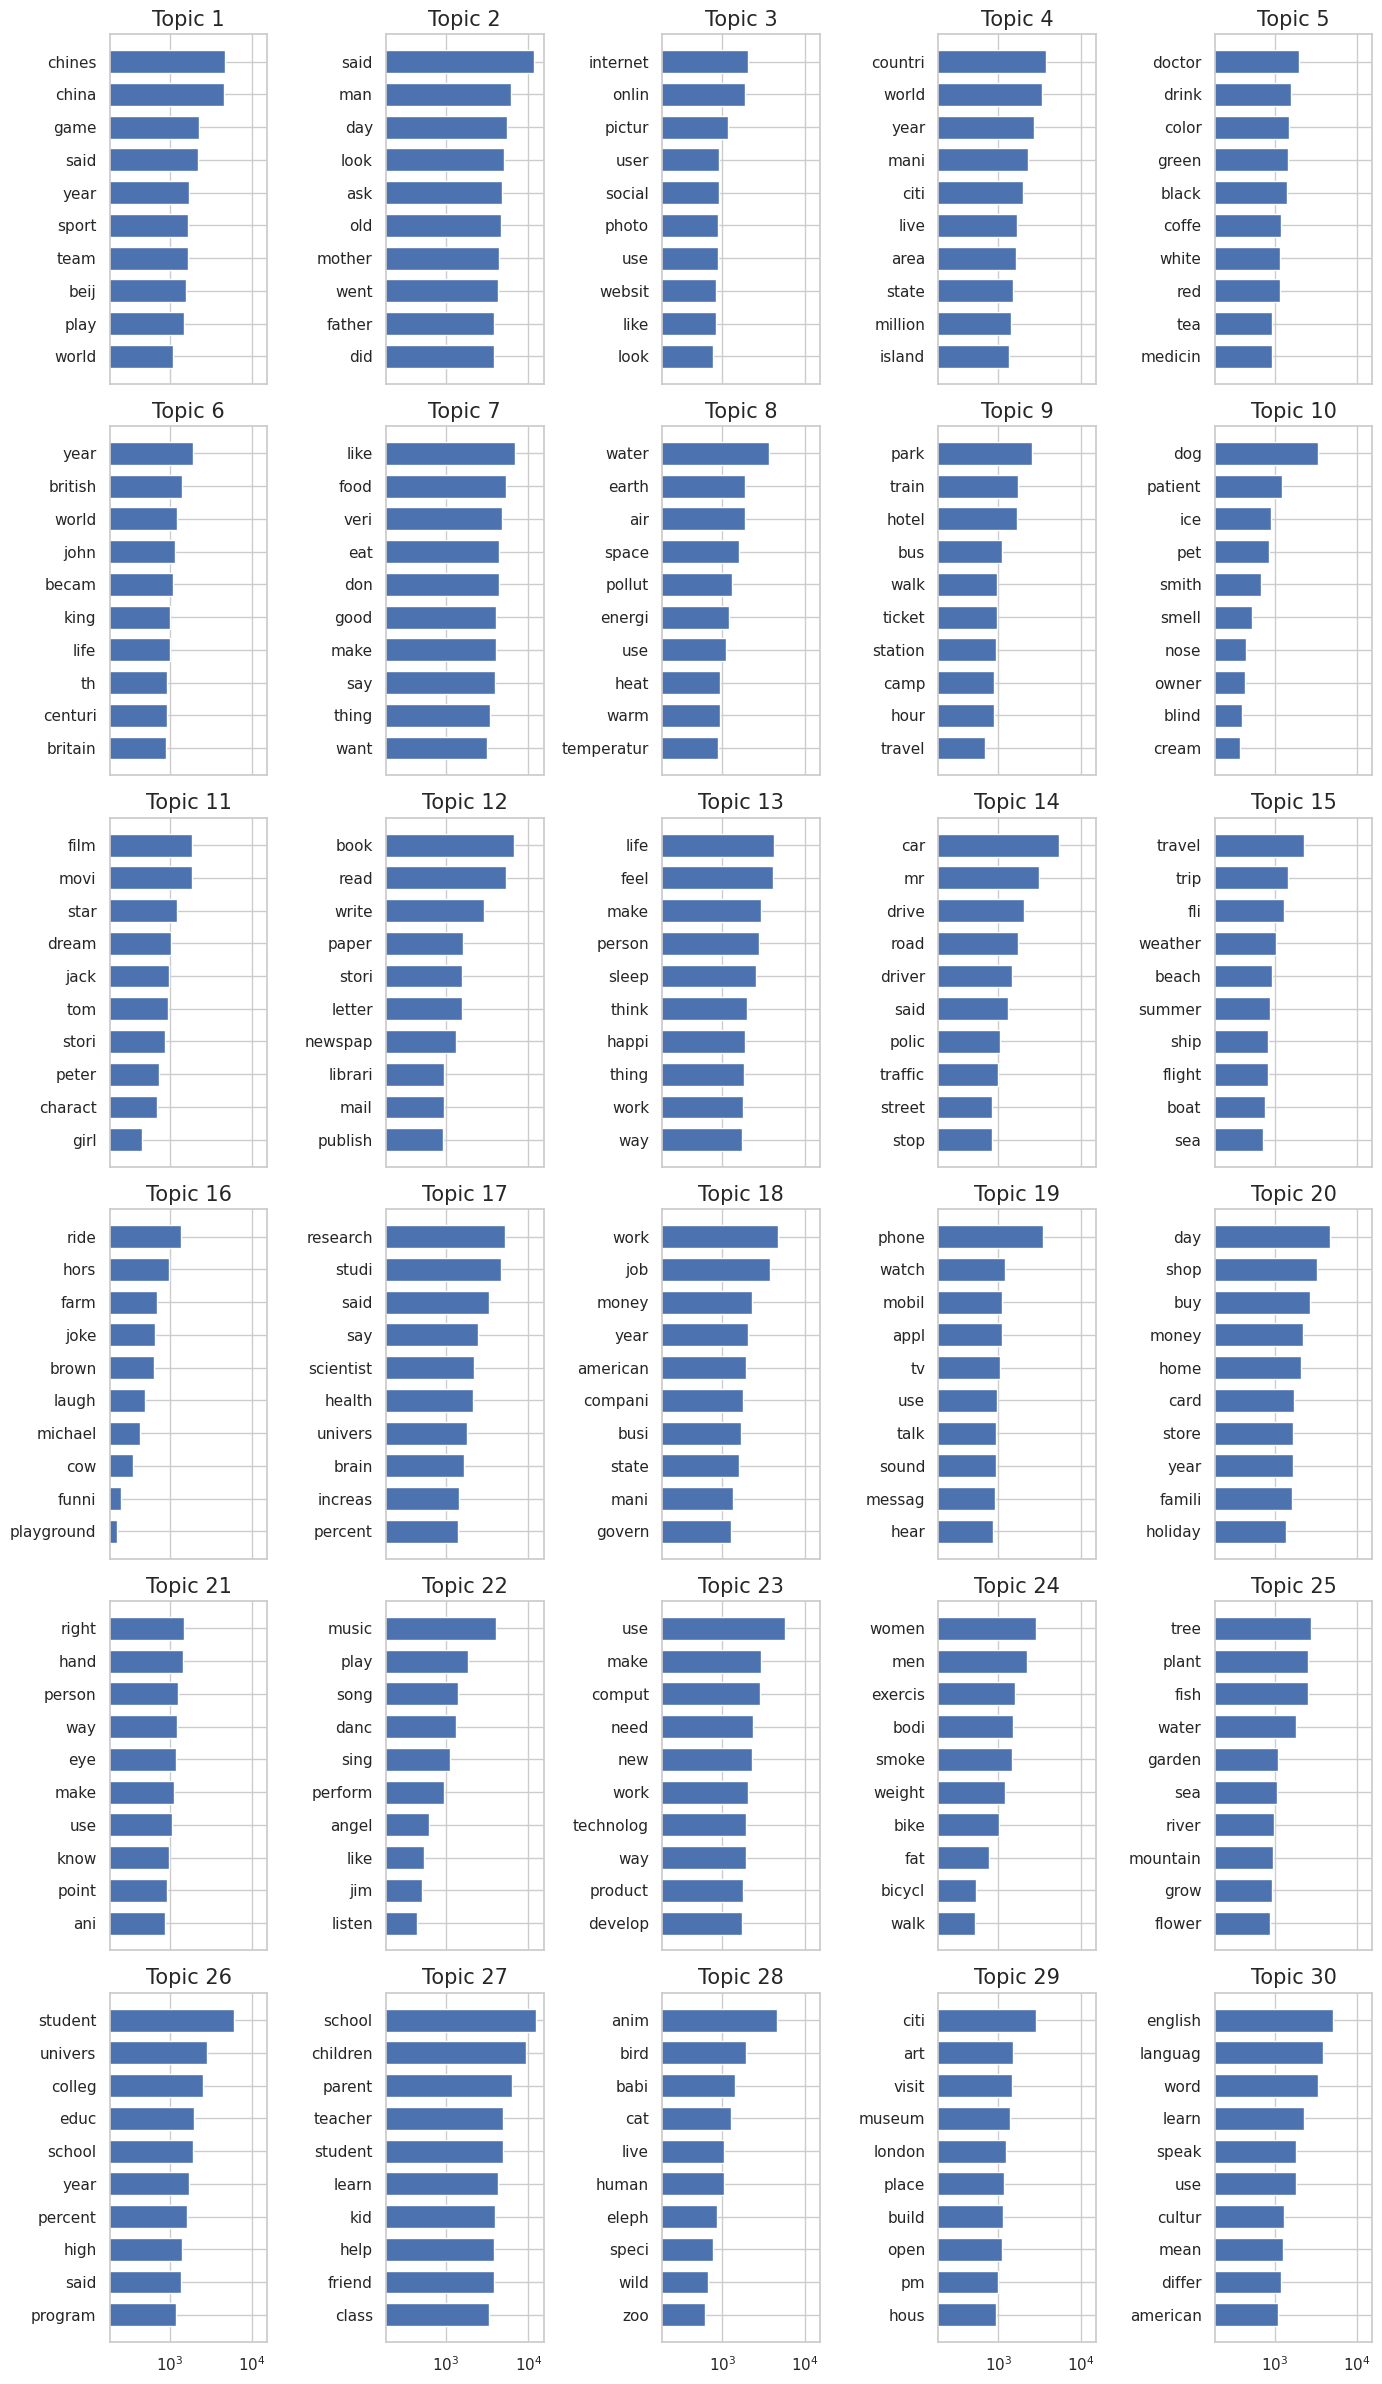

In [ ]:
# topic plot for lda with 30 topics
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

In [ ]:
doc = df_race_train.iloc[60]["article"] # get a random article
print(doc)

doc_vec = vectorizer.transform([doc])[0] # get document vector
topic_vec = lda.transform(doc_vec)[0] # get topic representation

print("Topic vector for article: \n",topic_vec) # print the topic vector for the article

# get top-10 topics for the document
sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

for i in range(10):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

I'm sure many of you have seen Star Wars, Jurassic Park, Multiplicity, or many of the other movies that describe cloning. Most of what you see in these movies is false. What you don't know is that cloning could be dangerous, to the clone and to our society as a whole. I think human cloning is wrong mainly for four reasons.
What about identity? Humans are promised the right to their own personalities. What would happen if we ignore those rights by giving them someone else's genetic identity? True, Cloning may prevent people from possessing their identities.
Also, these is a large power struggle here. Cloning means a degree of power and controls over another person's physical identity and that ignores their rights and their only personalities. The person doing the cloning would have more power than any parent would have.
Cloning would also deal with killing embryos  . You might not have known, but Dolly, the sheep that was cloned in 1996, was one of over 200 sheep embryos and hers was th

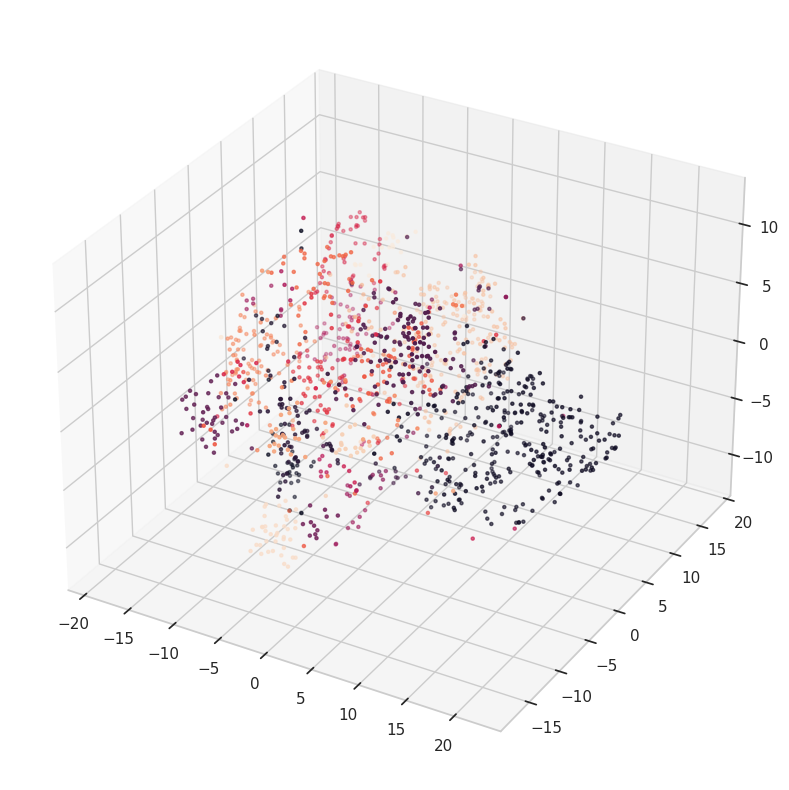

In [ ]:
from sklearn.preprocessing import LabelEncoder
# plot the documents in the test based on the most relevant topic
tsne_embedding = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_test))
tsne_embedding.shape

freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_documents_test)]

[x, y, z] = np.transpose(tsne_embedding)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(freq_topic), marker='.');

## Exploratory Data Analysis (EDA) Summary

### Dataset Splits
- **Train**: 87,866 examples  
- **Validation**: 4,887 examples  
- **Test**: 4,934 examples

- **Only** 27931 unique articles

### Question Distribution per Passage
- Distribution is similar across splits.
- **Train/Test**: Most articles have **3 questions**.
- **Validation**: Most common is **4 questions**.
- **645** articles have **only 1 question**.
- **1 article** contains the **maximum of 7 questions**.

### Answer Options (A, B, C, D)
- Distribution of options is almost equal across splits.
- Slight skew: **Option B** is **slightly less common** in the train set.
- On average, **3.5 options** per question.

### Article Statistics
- **Average length**: 287 words  
- **Shortest article**: 2-3 words (8 rows)
- **Longest article**: 1188 words  
- Note: Some articles (e.g., *Study Center Courses*, *Passage 1*) lack meaningful content but still contain valid questions.

### Question Statistics
- **Average question length**: 9.7 words  
- **Shortest**: `0` words (18 rows) — example: `"."` (either question in the text or not logical)
- **Longest**: 65 words  
- Question formats:
  - **Majority**: End with **`?`** (to-answer)
  - **High-portion**: End with **`_`** (to-fill)

### Top Question Types (frequency)
- **349×** Which of the following is TRUE according to the passage?  
- **282×** What can we learn from the passage?  
- **263×** Which of the following is TRUE?

### Part-of-Speech (POS) Analysis
- Most frequent: **Nouns**, followed by **verbs** and **pronouns**
- High-density articles in **nouns**, **verbs**, **adjectives** highlighted

### Word Cloud (Train Set)
- Most frequent words:  
  `people, one, said, make, student, world, children`  
  → Common and appropriate for a school-level dataset

### Text Clustering
- Tried **KMeans with 10 clusters**
- **WordTokenization**: Clusters are meaningful but show morphological variation (e.g., *language* vs *languages*)
- **Stemming**: Improves cluster coherence, removes word variants
- **MiniBatchKMeans**:
  - Best score at **28 clusters**
  - All silhouittes scores are low (< 0.007), suggesting poor clustering performance

### Dimensionality Reduction
- **Truncated SVD (3D)**: Not informative
- **t-SNE (3D)**: A bit less spread allocation

### Latent Dirichlet Analysis

- Used train set documents
- Extracted 30 topic
- Perprexity on test is 4096 for 30 topics and 4133 for 20 topics
- Visualised test in 3d using t-SNE and the most relevant topic

### Additional Notes
- **No article appears in more than one split**



# ========================================================================================================

### Conclusions and Results of the complex LLM

* Very good accuracy overall, as expected by such a huge model (**around 90%**).
* Intresting to see that one-shot prompting performs worse than zero-shot. One‐shot prompting can sometimes inadvertently bias the model toward that specific format or domain, causing it to overfit to the example rather than generalizing your actual question, while zero‐shot forces the model to rely solely on its pre‐trained knowledge. This can almost be confimed by the five-shot performing slighlty better than zero-shot.
* As expected, the more simple middel school questions were easier (**88% vs 96%**). This margin was bigger than expected. It shows that the level of the question is very important when measuring accuracy and must be taken into account when performing comparisons on different datasets.